# CSE 252A Computer Vision I Fall 2018 - Assignment 3

### Instructor: David Kriegman
### Assignment Published On: Wednesday, November 7, 2018
### Due On: Tuesday, November 20, 2018 11:59 pm

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* This assignment contains theoretical and programming exercises. If you plan to submit hand written answers for theoretical exercises, please be sure your writing is readable and merge those in order with the final pdf you create out of this notebook. You could fill the answers within the notebook iteself by creating a markdown cell. Please do not mention your explanatory answers in code comments.
* Programming aspects of this assignment must be completed using Python in this notebook.
* If you want to modify the skeleton code, you can do so. This has been provided just to provide you with a framework for the solution.
* You may use python packages for basic linear algebra (you can use numpy or scipy for basic operations), but you may not use packages that directly solve the problem.
* If you are unsure about using a specific package or function, then ask the instructor and teaching assistants for clarification.
* You must submit this notebook exported as a pdf. You must also submit this notebook as .ipynb file.
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* **Late policy** - 10% per day late penalty after due date up to 3 days.

## Problem 1: Epipolar Geometry [3 pts]
Consider two cameras whose image planes are the z=1 plane, and whose focal points are at (-20, 0, 0) and (20, 0, 0). We''ll call a point in the first camera (x, y), and a point in the second camera (u, v). Points in each camera are relative to the camera center. So, for example if (x, y) = (0, 0), this is really the point (-20, 0, 1) in world coordinates, while if (u, v) = (0, 0) this is the point (20, 0, 1).![Fig1.png](fig/fig1.png)
a) Suppose the points (x, y) = (12, 12) is matched to the point (u, v) = (1, 12). What is the 3D location of this point?

b) Consider points that lie on the line x + z = 0, y = 0. Use the same stereo set up as before. Write an analytic expression giving the disparity of a point on this line after it projects onto the two images, as a function of its position in the right image. So your expression should only involve the variables u and d (for disparity). Your expression only needs to be valid for points on the line that are in front of the cameras, i.e. with z > 1.

## Problem 2: Epipolar Rectification [4 pts]
In stereo vision, image rectification is a common preprocessing step to simplify the problem of finding
matching points between images. The goal is to warp image views such that the epipolar lines are
horizontal scan lines of the input images. Suppose that we have captured two images $I_A$ and $I_B$ from
identical calibrated cameras separated by a rigid transformation

$_{A}^{B}\textrm{T}= \begin{bmatrix}
R & t \\ 
0^T & 1
\end{bmatrix}$

Without loss of generality assume that camera A's optical center is positioned at the origin and that its optical axis is in the direction of the z-axis.

From the lecture, a rectifying transform for each image should map the epipole to a point infinitely far away in the horizontal direction $ H_{A}e_{A} = H_{B}e_{B} = [1, 0, 0]^T$. Consider the following special cases:

a) Pure horizontal translation $t = [t_x, 0, 0]^T$, R = I

b) Pure translation orthogonal to the optical axis $t = [t_x, t_y, 0]^T$, R = I

c) Pure translation along the optical axis $t = [0, 0, t_z]^T$, R = I

d) Pure rotation $t = [0, 0, 0]^T$, R is an arbitrary rotation matrix

For each of these cases, determine whether or not epipolar rectification is possible. Include the following information for each case
* The epipoles $e_A$ and $e_B$
* The equation of the epipolar line $l_B$ in $I_B$ corresponding to the point $[x_A, y_A, 1]^T$ in $I_A$ (if one exists)
* A plausible solution to the rectifying transforms $H_A$ and $H_B$ (if one exists) that attempts to minimize distortion (is as close as possible to a 2D rigid transformation). Note that the above 4 cases are special cases; a simple solution should become apparent by looking at the epipolar lines.

One or more of the above rigid transformations may be a degenerate case where rectification is not
possible or epipolar geometry does not apply. If so, explain why.

# Problem 3: Filtering [3 pts]

a) Consider smoothing an image with a 3x3 box filter and then computing the derivative in the x direction. What is a single convolution kernel that will implement this operation?

b) Give an example of a separable filter and compare the number of arithmetic operations it takes to convolve using that filter on an $n \times n$ image before and after separation.

## Problem 4: Sparse Stereo Matching [22 pts]

In this problem we will play around with sparse stereo matching methods. You will work on two image pairs, a warrior figure and a figure from the Matrix movies. These files both contain two images, two camera matrices, and set sets of corresponding points (extracted by manually clicking the images). For illustration, I have run my code on a third image pair (dino1.png, dino2.png). This data is also provided for you to debug your code, but you should only report results on warrior and matrix. In other words, where I include one (or a pair) of images in the assignment below, you will provide the same thing but for BOTH matrix and warrior. Note that the matrix image pair is harder, in the sense that the matching algorithms we are implementing will not work quite as well. You should expect good results, however, on warrior.

### Corner Detection [5 pts]
The first thing we need to do is to build a corner detector. This should be done according to http://cseweb.ucsd.edu/classes/fa18/cse252A-a/lec11.pdf. You should fill in the function <code>corner_detect</code> below, and take as <code>input corner_detect(image, nCorners, smoothSTD, windowSize)</code> where smoothSTD is the standard deviation of the smoothing kernel and windowSize is the window size for corner detector and non maximum suppression. In the lecture the corner detector was implemented using a hard threshold. Do not do that but instead return the nCorners strongest corners after non-maximum suppression. This way you can control exactly how many corners are returned. Run your code on all four images (with nCorners = 20) and show outputs as in Figure 2. You may find scipy.ndimage.filters.gaussian_filter easy to use for smoothing. In this problem, try different parameters and then comment on results.
1. windowSize = 3, 5, 9, 17
2. smoothSTD = 0.5, 1, 2, 4
![Dino corner 1](fig/dinoCorner1.png)
![Dino Corner 2](fig/dinoCorner2.png)

In [684]:
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

In [685]:
def rgb2gray(rgb):
    """ Convert rgb image to grayscale.
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [686]:
def convolution(image,window):
    #starting point for the window
    start = int((windowSize-1)/2)
    result = np.zeros((image.shape))
    for i in range(start,image.shape[0]-start):
        for j in range(start,image.shape[1]-start):
            result[i,j] = np.sum(image[i-start:i+start+1,j-start:j+start+1]*window)
    return result

def local_max(e,window):
    #starting point for the window
    start = int((windowSize-1)/2)
    result = np.zeros((e.shape))
    corner = dict()
    for i in range(start,e.shape[0]-start):
        for j in range(start,e.shape[1]-start):
            x = e[i-start:i+start+1,j-start:j+start+1]
            if (e[i][j] == np.max(x)):
                corner[e[i][j]] = [j,i]
    return corner

def corner_detect(image, nCorners, smoothSTD, windowSize):
    """Detect corners on a given image.

    Args:
        image: Given a grayscale image on which to detect corners.
        nCorners: Total number of corners to be extracted.
        smoothSTD: Standard deviation of the Gaussian smoothing kernel.
        windowSize: Window size for corner detector and non maximum suppression.

    Returns:
        Detected corners (in image coordinate) in a numpy array (n*2).

    """
    corners = []
    gauss_img = gaussian_filter(image,smoothSTD)
    dy,dx = np.gradient(gauss_img)
    window = np.ones(([windowSize,windowSize]))
    c_xx = convolution(dx*dx,window)
    c_yy = convolution(dy*dy,window)
    c_xy = convolution(dx*dy,window)
    e = np.zeros((gauss_img.shape))
    for i in range(gauss_img.shape[0]):
        for j in range(gauss_img.shape[1]):
            c = np.array([[c_xx[i][j], c_xy[i][j]], [c_xy[i][j], c_yy[i][j]]])
            l, v = np.linalg.eig(c)
            e[i][j] = np.min(l)
    corner = local_max(e,window)
    for key in sorted(corner.keys(),reverse=True):
        corners.append(corner[key])
    
    return np.array(corners[0:nCorners])

### windowSize = 17 smoothSTD = 4

In [4]:
# detect corners on warrior and matrix sets
# adjust your corner detection parameters here
nCorners = 20
smoothSTD = 4
windowSize = 17

# read images and detect corners on images
imgs_mat = []
crns_mat = []
imgs_war = []
crns_war = []
for i in range(2):
    img_mat = imread('p4/matrix/matrix' + str(i) + '.png')
    #imgs_mat.append(rgb2gray(img_mat))
    # downsize your image in case corner_detect runs slow in test
    imgs_mat.append(rgb2gray(img_mat)[::2, ::2])
    crns_mat.append(corner_detect(imgs_mat[i], nCorners, smoothSTD, windowSize))
    
    img_war = imread('p4/warrior/warrior' + str(i) + '.png')
    #imgs_war.append(rgb2gray(img_war))
    # downsize your image in case corner_detect runs slow in test
    imgs_war.append(rgb2gray(img_war)[::2, ::2])
    crns_war.append(corner_detect(imgs_war[i], nCorners, smoothSTD, windowSize))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


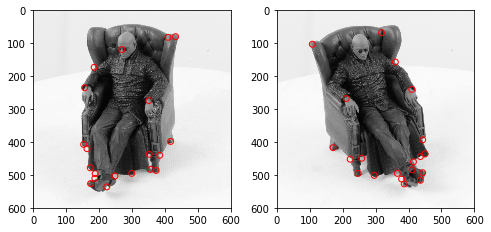

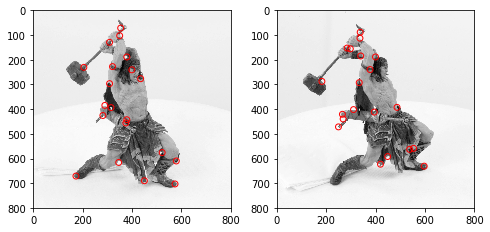

In [5]:
def show_corners_result(imgs, corners):
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(221)
    ax1.imshow(imgs[0], cmap='gray')
    ax1.scatter(corners[0][:, 0], corners[0][:, 1], s=35, edgecolors='r', facecolors='none')

    ax2 = fig.add_subplot(222)
    ax2.imshow(imgs[1], cmap='gray')
    ax2.scatter(corners[1][:, 0], corners[1][:, 1], s=35, edgecolors='r', facecolors='none')
    plt.show()

show_corners_result(imgs_mat, crns_mat)
show_corners_result(imgs_war, crns_war)

### windowSize = 17 smoothSTD = 0.5

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


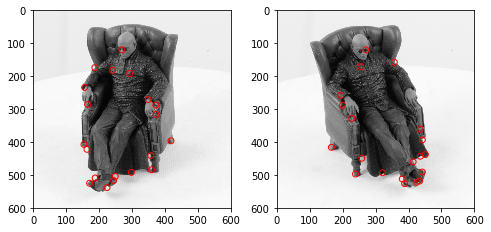

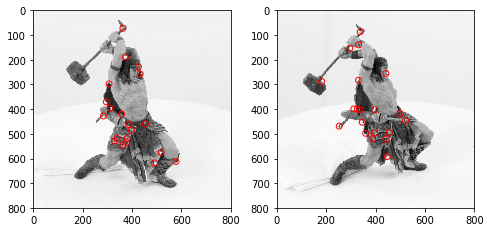

In [6]:
nCorners = 20
smoothSTD = 0.5
windowSize = 17

# read images and detect corners on images
imgs_mat = []
crns_mat = []
imgs_war = []
crns_war = []
for i in range(2):
    img_mat = imread('p4/matrix/matrix' + str(i) + '.png')
    imgs_mat.append(rgb2gray(img_mat)[::2, ::2])
    crns_mat.append(corner_detect(imgs_mat[i], nCorners, smoothSTD, windowSize))
    img_war = imread('p4/warrior/warrior' + str(i) + '.png')
    imgs_war.append(rgb2gray(img_war)[::2, ::2])
    crns_war.append(corner_detect(imgs_war[i], nCorners, smoothSTD, windowSize))
show_corners_result(imgs_mat, crns_mat)
show_corners_result(imgs_war, crns_war)

### windowSize = 3 smoothSTD = 4

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


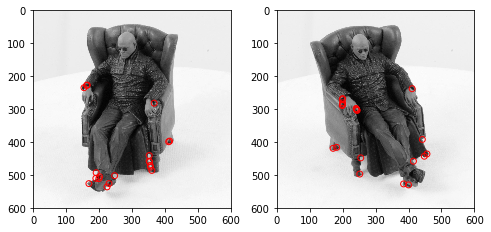

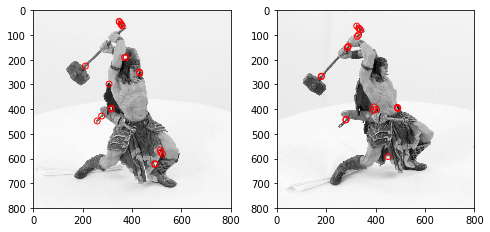

In [7]:
nCorners = 20
smoothSTD = 4
windowSize = 3

# read images and detect corners on images
imgs_mat = []
crns_mat = []
imgs_war = []
crns_war = []
for i in range(2):
    img_mat = imread('p4/matrix/matrix' + str(i) + '.png')
    imgs_mat.append(rgb2gray(img_mat)[::2, ::2])
    crns_mat.append(corner_detect(imgs_mat[i], nCorners, smoothSTD, windowSize))
    img_war = imread('p4/warrior/warrior' + str(i) + '.png')
    imgs_war.append(rgb2gray(img_war)[::2, ::2])
    crns_war.append(corner_detect(imgs_war[i], nCorners, smoothSTD, windowSize))
show_corners_result(imgs_mat, crns_mat)
show_corners_result(imgs_war, crns_war)

### windowSize = 3 smoothSTD = 0.5

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


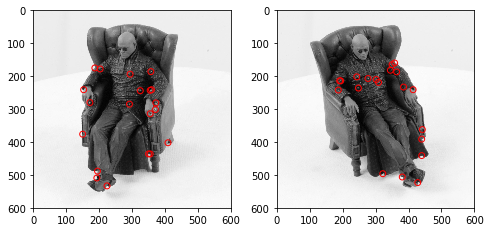

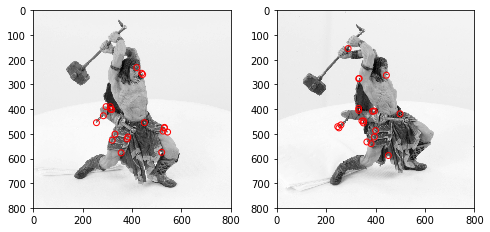

In [8]:
nCorners = 20
smoothSTD = 0.5
windowSize = 3

# read images and detect corners on images
imgs_mat = []
crns_mat = []
imgs_war = []
crns_war = []
for i in range(2):
    img_mat = imread('p4/matrix/matrix' + str(i) + '.png')
    imgs_mat.append(rgb2gray(img_mat)[::2, ::2])
    crns_mat.append(corner_detect(imgs_mat[i], nCorners, smoothSTD, windowSize))
    img_war = imread('p4/warrior/warrior' + str(i) + '.png')
    imgs_war.append(rgb2gray(img_war)[::2, ::2])
    crns_war.append(corner_detect(imgs_war[i], nCorners, smoothSTD, windowSize))
show_corners_result(imgs_mat, crns_mat)
show_corners_result(imgs_war, crns_war)

### Comment on result

For windowSize, I found that if with the windowSize decrease, some corners are more likely to be very close to each other. When the windowSize is 3, we can detect around five corners near the hair of warrior which are supposed to be the same corner. When the windowSize is 17, the corners are separable in both images. Those fact makes sense because small window may detect a corner many times so that there are many detected points stick together. To detect more distinct corners, we'd better incease the windowSize.

The smoothSTD, which is Standard deviation of the Gaussian smoothing kernel, aims to blur and smooth the image detail such that the noise in the images will be reduced. When the smoothSTD is 0.5, we may detect many inappropriate corners, such as the several corners in the men's shirt in the matrix image. When the smoothSTD is 4, many distinct corner appears, such as the corner of the chair in the matrix image. To detect more distinct corners, we'd better incease the smoothSTD.

### NCC (Normalized Cross-Correlation) Matching [2 pts]

Write a function ncc_match that implements the NCC matching algorithm for two input windows.
NCC = $\sum_{i,j}\tilde{W_1} (i,j)\cdot \tilde{W_2} (i,j)$ where $\tilde{W} = \frac{W - \overline{W}}{\sqrt{\sum_{k,l}(W(k,l) - \overline{W})^2}}$ is a mean-shifted and normalized version of the window and $\overline{W}$ is the mean pixel value in the window W.

In [687]:
def ncc_match(img1, img2, c1, c2, R):
    """Compute NCC given two windows.

    Args:
        img1: Image 1.
        img2: Image 2.
        c1: Center (in image coordinate) of the window in image 1.
        c2: Center (in image coordinate) of the window in image 2.
        R: R is the radius of the patch, 2 * R + 1 is the window size

    Returns:
        NCC matching score for two input windows.

    """
    
    """
    Your code here:
    """
    sum1 = 0
    sum2 = 0
    matching_score = 0
    mean1=[]
    mean2=[]
    for i in range(-R, R+1):
        for j in range(-R, R+1):
            mean1.append(img1[c1[1]+i][c1[0]+j])
            mean2.append(img2[c2[1]+i][c2[0]+j])
    w1_m = np.mean(mean1)
    w2_m = np.mean(mean2)
    for i in range(-R, R+1):
        for j in range(-R, R+1):
            sum1 += (img1[c1[1]+i][c1[0]+j] - w1_m)**2
            sum2 += (img2[c2[1]+i][c2[0]+j] - w2_m)**2
    for i in range(-R, R+1):
        for j in range(-R, R+1):                       
            w1 = (img1[c1[1]+i][c1[0]+j] - w1_m)/np.sqrt(sum1)
            w2 = (img2[c2[1]+i][c2[0]+j] - w2_m)/np.sqrt(sum2)
            matching_score += w1*w2    
    return matching_score

In [464]:
# test NCC match
img1 = np.array([[1, 2, 3, 4], [4, 5, 6, 8], [7, 8, 9, 4]])
img2 = np.array([[1, 2, 1, 3], [6, 5, 4, 4], [9, 8, 7, 3]])
print (ncc_match(img1, img2, np.array([1, 1]), np.array([1, 1]), 1))
# should print 0.8546
print (ncc_match(img1, img2, np.array([2, 1]), np.array([2, 1]), 1))
# should print 0.8457
print (ncc_match(img1, img2, np.array([1, 1]), np.array([2, 1]), 1))
# should print 0.6258

0.8546547739343037
0.845761528217442
0.6258689611426175


### Naive Matching [4 pts]

Equipped with the corner detector and the NCC matching function, we are ready to start finding correspondances. One naive strategy is to try and find the best match between the two sets of corner points. Write a script that does this, namely, for each corner in image1, find the best match from the detected corners in image2 (or, if the NCC match score is too low, then return no match for that point). You will have to figure out a good threshold (NCCth) value by experimentation. Write a function naiveCorrespondanceMatching.m and call it as below. Examine your results for 10, 20, and 30 detected corners in each image. Choose a number of detected corners to the maximize the number of correct matching pairs. naive_matching will call your NCC mathching code. ![Dino match](fig/dinoMatch.png)

In [688]:
def naive_matching(img1, img2, corners1, corners2, R, NCCth):
    """Compute NCC given two windows.

    Args:
        img1: Image 1.
        img2: Image 2.
        corners1: Corners in image 1 (nx2)
        corners2: Corners in image 2 (nx2)
        R: NCC matching radius
        NCCth: NCC matching score threshold

    Returns:
        NCC matching result a list of tuple (c1, c2), 
        c1 is the 1x2 corner location in image 1, 
        c2 is the 1x2 corner location in image 2. 

    """
    
    """
    Your code here:
    """
    matching = []
    ncc = np.zeros([corners1.shape[0], corners2.shape[0]])
    for i in range(corners1.shape[0]):
        for j in range(corners2.shape[0]):
            ncc[i][j] = ncc_match(img1, img2, corners1[i], corners2[j], R)
            if ncc[i][j] > NCCth:
                matching.append((corners1[i], corners2[j]))
    return matching

### 30 detected corners (best)

In [250]:
# detect corners on warrior and matrix sets
# adjust your corner detection parameters here
nCorners = 30
smoothSTD = 2
windowSize = 11

# read images and detect corners on images
imgs_mat = []
crns_mat = []
imgs_war = []
crns_war = []
for i in range(2):
    img_mat = imread('p4/matrix/matrix' + str(i) + '.png')
    imgs_mat.append(rgb2gray(img_mat))
    # downsize your image in case corner_detect runs slow in test
    #imgs_mat.append(rgb2gray(img_mat)[::2, ::2])
    crns_mat.append(corner_detect(imgs_mat[i], nCorners, smoothSTD, windowSize))
    
    img_war = imread('p4/warrior/warrior' + str(i) + '.png')
    imgs_war.append(rgb2gray(img_war))
    #imgs_war.append(rgb2gray(img_war)[::2, ::2])
    crns_war.append(corner_detect(imgs_war[i], nCorners, smoothSTD, windowSize))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [251]:
# match corners
R = 25
NCCth = 0.71
matching_mat = naive_matching(imgs_mat[0]/255, imgs_mat[1]/255, crns_mat[0], crns_mat[1], R, NCCth)
matching_war = naive_matching(imgs_war[0]/255, imgs_war[1]/255, crns_war[0], crns_war[1], R, NCCth)

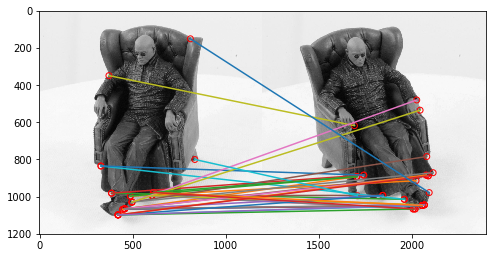

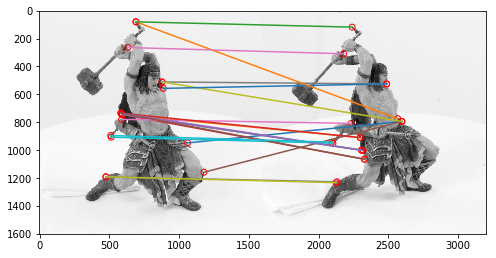

In [252]:
# plot matching result
def show_matching_result(img1, img2, matching):
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(np.hstack((img1, img2)), cmap='gray') # two dino images are of different sizes, resize one before use
    for p1, p2 in matching:
        plt.scatter(p1[0], p1[1], s=35, edgecolors='r', facecolors='none')
        plt.scatter(p2[0] + img1.shape[1], p2[1], s=35, edgecolors='r', facecolors='none')
        plt.plot([p1[0], p2[0] + img1.shape[1]], [p1[1], p2[1]])
    plt.savefig('dino_matching.png')
    plt.show()
    
show_matching_result(imgs_mat[0], imgs_mat[1], matching_mat)
show_matching_result(imgs_war[0], imgs_war[1], matching_war)

### 20 detected corners (good)

In [253]:
# detect corners on warrior and matrix sets
# adjust your corner detection parameters here
nCorners = 20
smoothSTD = 2
windowSize = 11

# read images and detect corners on images
imgs_mat = []
crns_mat = []
imgs_war = []
crns_war = []
for i in range(2):
    img_mat = imread('p4/matrix/matrix' + str(i) + '.png')
    imgs_mat.append(rgb2gray(img_mat))
    # downsize your image in case corner_detect runs slow in test
    #imgs_mat.append(rgb2gray(img_mat)[::2, ::2])
    crns_mat.append(corner_detect(imgs_mat[i], nCorners, smoothSTD, windowSize))
    
    img_war = imread('p4/warrior/warrior' + str(i) + '.png')
    imgs_war.append(rgb2gray(img_war))
    #imgs_war.append(rgb2gray(img_war)[::2, ::2])
    crns_war.append(corner_detect(imgs_war[i], nCorners, smoothSTD, windowSize))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


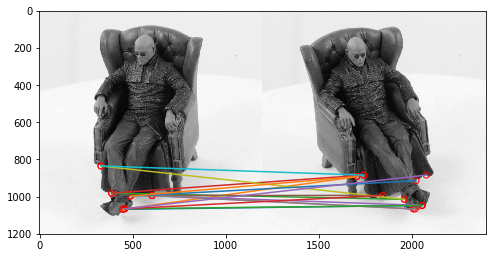

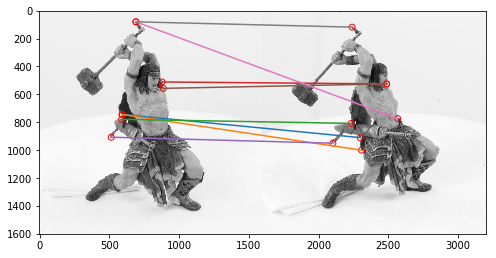

In [254]:
# match corners
R = 25
NCCth = 0.71
matching_mat = naive_matching(imgs_mat[0]/255, imgs_mat[1]/255, crns_mat[0], crns_mat[1], R, NCCth)
matching_war = naive_matching(imgs_war[0]/255, imgs_war[1]/255, crns_war[0], crns_war[1], R, NCCth)
    
show_matching_result(imgs_mat[0], imgs_mat[1], matching_mat)
show_matching_result(imgs_war[0], imgs_war[1], matching_war)

### 10 detected corners (bad)

In [255]:
# detect corners on warrior and matrix sets
# adjust your corner detection parameters here
nCorners = 10
smoothSTD = 2
windowSize = 11

# read images and detect corners on images
imgs_mat = []
crns_mat = []
imgs_war = []
crns_war = []
for i in range(2):
    img_mat = imread('p4/matrix/matrix' + str(i) + '.png')
    imgs_mat.append(rgb2gray(img_mat))
    # downsize your image in case corner_detect runs slow in test
    #imgs_mat.append(rgb2gray(img_mat)[::2, ::2])
    crns_mat.append(corner_detect(imgs_mat[i], nCorners, smoothSTD, windowSize))
    
    img_war = imread('p4/warrior/warrior' + str(i) + '.png')
    imgs_war.append(rgb2gray(img_war))
    #imgs_war.append(rgb2gray(img_war)[::2, ::2])
    crns_war.append(corner_detect(imgs_war[i], nCorners, smoothSTD, windowSize))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


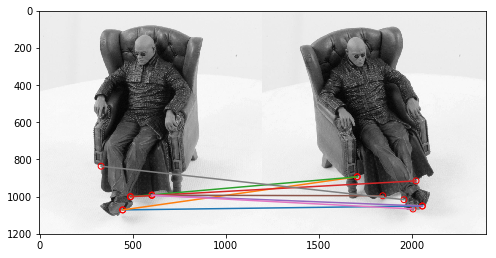

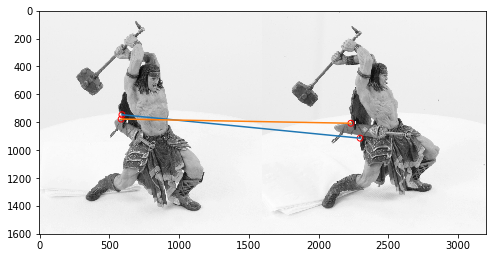

In [256]:
# match corners
R = 25
NCCth = 0.71
matching_mat = naive_matching(imgs_mat[0]/255, imgs_mat[1]/255, crns_mat[0], crns_mat[1], R, NCCth)
matching_war = naive_matching(imgs_war[0]/255, imgs_war[1]/255, crns_war[0], crns_war[1], R, NCCth)
    
show_matching_result(imgs_mat[0], imgs_mat[1], matching_mat)
show_matching_result(imgs_war[0], imgs_war[1], matching_war)

### Epipolar Geometry [4 pts]

Using the fundamental_matrix function, and the corresponding points provided in cor1.npy and cor2.npy, calculate the fundamental matrix. 


Using this fundamental matrix, plot the epipolar lines in both image pairs across all images. For this part you may want to complete the function plot_epipolar_lines. Shown your result for matrix and warrior as the figure below. 
![Dino Epipolar](fig/dinoEpi1.png)
![Dino Epipolar](fig/dinoEpi2.png)

Also, write the script to calculate the epipoles for a given Fundamental matrix and corner point correspondences in the two images.

In [795]:
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
from scipy.io import loadmat

def compute_fundamental(x1,x2):
    """    Computes the fundamental matrix from corresponding points 
        (x1,x2 3*n arrays) using the 8 point algorithm.
        Each row in the A matrix below is constructed as
        [x'*x, x'*y, x', y'*x, y'*y, y', x, y, 1] 
    """
    
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")
    
    # build matrix for equations
    A = np.zeros((n,9))
    for i in range(n):
        A[i] = [x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i]*x2[2,i],
                x1[1,i]*x2[0,i], x1[1,i]*x2[1,i], x1[1,i]*x2[2,i],
                x1[2,i]*x2[0,i], x1[2,i]*x2[1,i], x1[2,i]*x2[2,i] ]
            
    # compute linear least square solution
    U,S,V = np.linalg.svd(A)
    F = V[-1].reshape(3,3)
        
    # constrain F
    # make rank 2 by zeroing out last singular value
    U,S,V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U,np.dot(np.diag(S),V))
    
    return F/F[2,2]


def fundamental_matrix(x1,x2):
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2],axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1,0,-S1*mean_1[0]],[0,S1,-S1*mean_1[1]],[0,0,1]])
    x1 = np.dot(T1,x1)
    
    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2],axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2,0,-S2*mean_2[0]],[0,S2,-S2*mean_2[1]],[0,0,1]])
    x2 = np.dot(T2,x2)

    # compute F with the normalized coordinates
    F = compute_fundamental(x1,x2)

    # reverse normalization
    F = np.dot(T1.T,np.dot(F,T2))

    return F/F[2,2]
def compute_epipole(F):
    '''
    This function computes the epipoles for a given fundamental matrix and corner point correspondences
    input:
    F--> Fundamental matrix
    output:
    e1--> corresponding epipole in image 1
    e2--> epipole in image2
    '''
#     l1, v1 = np.linalg.eig(F)
#     l2, v2 = np.linalg.eig(F.T)
#     for x1 in range(len(l1)):
#         if l1[x1] < 10**-6:
#             l1[x1] = 0 
#             e1 = v1[:,x1]
#     for x2 in range(len(l2)):
#         if l2[x2] < 10**-6:
#             l2[x2] = 0
#             e2 = v2[:,x2]
    U,S,Vh = np.linalg.svd(F)

    e1 = U[:, -1]
    e2 = Vh[-1]
    
    e1 = e1/e1[-1]
    e2 = e2/e2[-1]
    
    return e1, e2

In [691]:
def plot_epipolar_lines(img1,img2, cor1, cor2):
    """Plot epipolar lines on image given image, corners

    Args:
        img1: Image 1.
        img2: Image 2.
        cor1: Corners in homogeneous image coordinate in image 1 (3xn)
        cor2: Corners in homogeneous image coordinate in image 2 (3xn)

    """
    
    """
    Your code here:
    """
    F = fundamental_matrix(cor1, cor2) 
#first image
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(img1, cmap = 'gray') 
    for i in range(cor2.shape[1]):
        a1 = np.dot(F, cor2[:,i])
        y_s1 = a1[2]/(-a1[1])
        y_e1 = (img1.shape[1]*a1[0]+a1[2])/(-a1[1])
        plt.plot([0, img1.shape[1]], [y_s1, y_e1], color = 'b')
        plt.axis([0,img1.shape[1],img1.shape[0],0])
    for i in range(cor1.shape[1]):
        plt.scatter(cor1[0][i], cor1[1][i], s=45, edgecolors='g', facecolors='b')
    plt.show()
#second image
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(img2, cmap = 'gray')
    for i in range(cor2.shape[1]):
        plt.scatter(cor2[0][i], cor2[1][i], s=45, edgecolors='g', facecolors='b')
    for i in range(cor1.shape[1]):
        a2 = np.dot(F.T, cor1[:,i])
        y_s2 = a2[2]/(-a2[1])
        y_e2 = (img2.shape[1]*a2[0]+a2[2])/(-a2[1])
        plt.plot([0, img2.shape[1]], [y_s2, y_e2], color = 'b')
        plt.axis([0,img2.shape[1],img2.shape[0],0])
    
    plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


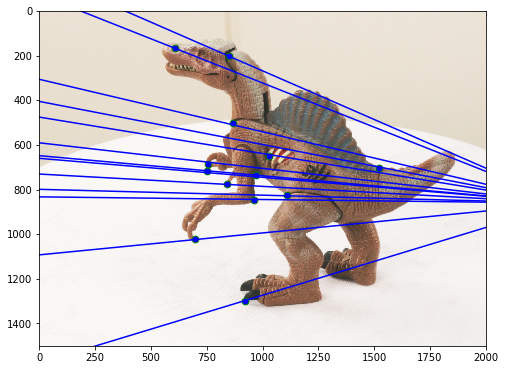

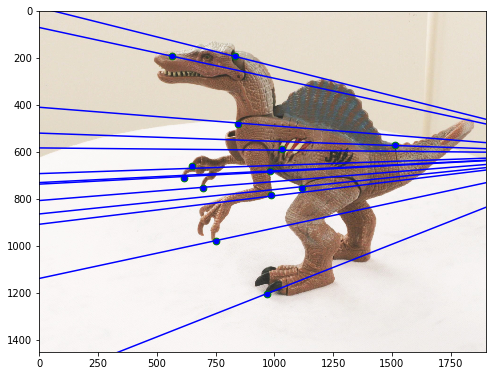

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


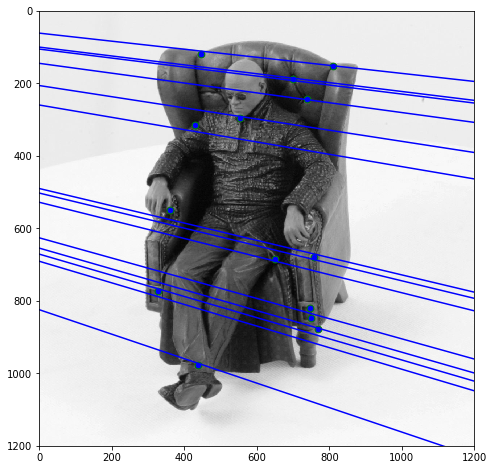

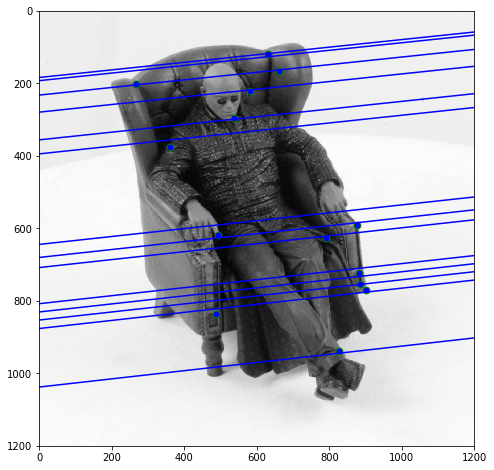

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


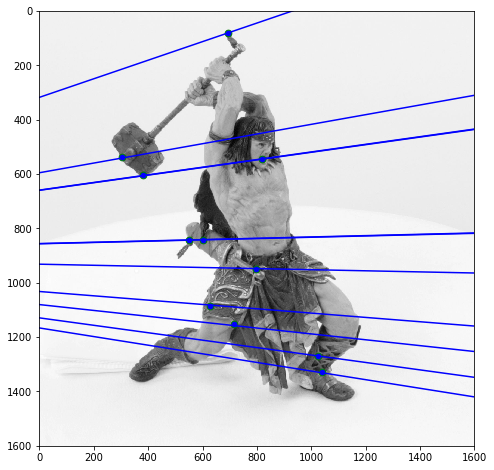

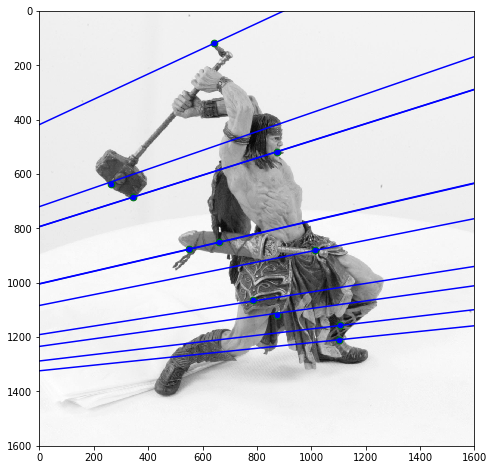

In [389]:
# replace images and corners with those of matrix and warrior
I1 = imread("./p4/dino/dino0.png")
I2 = imread("./p4/dino/dino1.png")

cor1 = np.load("./p4/dino/cor1.npy")
cor2 = np.load("./p4/dino/cor2.npy")

plot_epipolar_lines(I1,I2,cor1,cor2)



# replace images and corners with those of matrix and warrior
I1 = rgb2gray(imread("./p4/matrix/matrix0.png"))
I2 = rgb2gray(imread("./p4/matrix/matrix1.png"))

cor1 = np.load("./p4/matrix/cor1.npy")
cor2 = np.load("./p4/matrix/cor2.npy")

plot_epipolar_lines(I1,I2,cor1,cor2)

# replace images and corners with those of matrix and warrior
I1 = rgb2gray(imread("./p4/warrior/warrior0.png"))
I2 = rgb2gray(imread("./p4/warrior/warrior1.png"))

cor1 = np.load("./p4/warrior/cor1.npy")
cor2 = np.load("./p4/warrior/cor2.npy")

plot_epipolar_lines(I1,I2,cor1,cor2)



### Image Rectification [3 pts]
 An interesting case for epipolar geometry occurs when two images are parallel to each other. In this case, there is no rotation component involved between the two images and the essential matrix is $\texttt{E}=[\boldsymbol{T_{x}}]\boldsymbol{R}=[\boldsymbol{T_{x}}]$. Also if you observe the epipolar lines $\boldsymbol{l}$ and $\boldsymbol{l^{'}}$ for parallel images, they are horizontal and consequently, the corresponding epipolar lines share the same vertical coordinate. Therefore the process of making images parallel becomes useful while discerning the relationships between corresponding points in images.
 Rectifying a pair of images can also be done for uncalibrated camera images (i.e. we do not require the camera matrix of intrinsic parameters). Using the fundamental matrix we can find the pair of epipolar lines $\boldsymbol{l_i}$ and $\boldsymbol{l^{'}_i}$ for each of the correspondances. The intersection of these lines will give us the respective epipoles $\boldsymbol{e}$ and $\boldsymbol{e^{'}}$.  Now to make the epipolar lines to be parallel we need to map the epipoles to infinity. Hence , we need to find a homography that maps the epipoles to infinity. The method to find the homography has been implemented for you. You can read more about the method used to estimate the homography in the paper "Theory and Practice of Projective Rectification" by Richard Hartley.
 ![Image Rectification Setup](image_rectification.png)
 Using the compute_epipoles function from the previous part and the given compute_matching_homographies function, find the rectified images and plot the parallel epipolar lines using the plot_epipolar_lines function from above. You need to do this for both the matrix and the warrior images. A sample output will look as below:
 ![sample rectification](sample_rectification.png)

In [796]:
def compute_matching_homographies(e2, F, im2, points1, points2):
    
    '''This function computes the homographies to get the rectified images
    input:
    e2--> epipole in image 2
    F--> the Fundamental matrix
    im2--> image2
    points1 --> corner points in image1
    points2--> corresponding corner points in image2
    output:
    H1--> Homography for image 1
    H2--> Homography for image 2
    '''
    # calculate H2
    width = im2.shape[1]
    height = im2.shape[0]

    T = np.identity(3)
    T[0][2] = -1.0 * width / 2
    T[1][2] = -1.0 * height / 2

    e = T.dot(e2)
    e1_prime = e[0]
    e2_prime = e[1]
    if e1_prime >= 0:
        alpha = 1.0
    else:
        alpha = -1.0

    R = np.identity(3)
    R[0][0] = alpha * e1_prime / np.sqrt(e1_prime**2 + e2_prime**2)
    R[0][1] = alpha * e2_prime / np.sqrt(e1_prime**2 + e2_prime**2)
    R[1][0] = - alpha * e2_prime / np.sqrt(e1_prime**2 + e2_prime**2)
    R[1][1] = alpha * e1_prime / np.sqrt(e1_prime**2 + e2_prime**2)

    f = R.dot(e)[0]
    G = np.identity(3)
    G[2][0] = - 1.0 / f

    H2 = np.linalg.inv(T).dot(G.dot(R.dot(T)))

    # calculate H1
    e_prime = np.zeros((3, 3))
    e_prime[0][1] = -e2[2]
    e_prime[0][2] = e2[1]
    e_prime[1][0] = e2[2]
    e_prime[1][2] = -e2[0]
    e_prime[2][0] = -e2[1]
    e_prime[2][1] = e2[0]

    v = np.array([1, 1, 1])
    M = e_prime.dot(F) + np.outer(e2, v)

    points1_hat = H2.dot(M.dot(points1)).T
    points2_hat = H2.dot(points2).T

    W = points1_hat / points1_hat[:, 2].reshape(-1, 1)
    b = (points2_hat / points2_hat[:, 2].reshape(-1, 1))[:, 0]

    # least square problem
    a1, a2, a3 = np.linalg.lstsq(W, b)[0]
    HA = np.identity(3)
    HA[0] = np.array([a1, a2, a3])

    H1 = HA.dot(H2).dot(M)
    return H1, H2

def image_rectification(im1,im2,points1,points2):
    '''this function provides the rectified images along with the new corner points as outputs for a given pair of 
    images with corner correspondences
    input:
    im1--> image1
    im2--> image2
    points1--> corner points in image1
    points2--> corner points in image2
    outpu:
    rectified_im1-->rectified image 1
    rectified_im2-->rectified image 2
    new_cor1--> new corners in the rectified image 1
    new_cor2--> new corners in the rectified image 2
    '''
    "your code here"
    F = fundamental_matrix(points1, points2)
    e1,e2 = compute_epipole(F)
    H1, H2 = compute_matching_homographies(e2, F.T, im2, points1, points2)
    rectified_im1 = mapping(np.ones(im1.shape), H1, im1)
    rectified_im2 = mapping(np.ones(im2.shape), H2, im2)
    new_cor1 = np.matmul(H1,points1)
    new_cor2 = np.matmul(H2,points2)
    new_cor1 = new_cor1/new_cor1[2,:]
    new_cor2 = new_cor2/new_cor2[2,:]

    return rgb2gray(rectified_im1),rgb2gray(rectified_im2),new_cor1,new_cor2

In [797]:
def mapping(target_image, H, source_image):
    source_size = np.shape(source_image)
    source_points = np.array([[0,0],[source_size[1],0],[source_size[1], source_size[0]],[0, source_size[0]]]).T
    target_size = np.shape(target_image)
    p = np.ones((3,))
    for i in range(0, target_size[1]):
        for j in range(0,target_size[0]):
            p[0]=i
            p[1]=j
            imap = np.matmul(np.linalg.inv(H),p)
            imap = imap[:2]/imap[2]
            if int(imap[1])>=0 and int(imap[1])<source_size[0] and int(imap[0])>=0 and int(imap[0])<source_size[1]:
                target_image[j,i,:]= source_image[int(imap[1]),int(imap[0]),:]
    return target_image

In [798]:
I1=imread("./p4/matrix/matrix0.png")
I2=imread("./p4/matrix/matrix1.png")
cor1 = np.load("./p4/matrix/cor1.npy")
cor2 = np.load("./p4/matrix/cor2.npy")
I3=imread("./p4/warrior/warrior0.png")
I4=imread("./p4/warrior/warrior1.png")
cor3 = np.load("./p4/warrior/cor1.npy")
cor4 = np.load("./p4/warrior/cor2.npy")

rectified_im1,rectified_im2,new_cor1,new_cor2 = image_rectification(I1,I2,cor1,cor2)
rectified_im3,rectified_im4,new_cor3,new_cor4 = image_rectification(I3,I4,cor3,cor4)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: FutureWarning: `rcond` parameter will

### Matching Using epipolar geometry[4 pts]

We will now use the epipolar geometry constraint on the rectified images and updated corner points to build a better matching algorithm. First, detect 10 corners
in Image1. Then, for each corner, do a linesearch along the corresponding parallel epipolar line in Image2.
Evaluate the NCC score for each point along this line and return the best match (or no match if all
scores are below the NCCth). R is the radius (size) of the NCC patch in the code below.  You do not
have to run this in both directions. Show your result as in the naive matching part. Execute this for the warrior and matrix images.

In [829]:
def display_correspondence(img1, img2, corrs):
    """Plot matching result on image pair given images and correspondences

    Args:
        img1: Image 1.
        img2: Image 2.
        corrs: Corner correspondence

    """
    
    """
    Your code here.
    You may refer to the show_matching_result function
    """
    show_matching_result(img1, img2, corrs)
def correspondence_matching_epipole(img1, img2, corners1, F, R, NCCth):
    """Find corner correspondence along epipolar line.

    Args:
        img1: Image 1.
        img2: Image 2.
        corners1: Detected corners in image 1.
        F: Fundamental matrix calculated using given ground truth corner correspondences.
        R: NCC matching window radius.
        NCCth: NCC matching threshold.
    
    
    Returns:
        Matching result to be used in display_correspondence function

    """
    """
    Your code here.
    """
    matching = []
    n = corners1.shape[0]
    cor1 = np.row_stack((corners1.T, [1]*n))
    for i in range(n):
        l_para2 = np.dot(F.T, cor1[:,i])
        x2 = img2.shape[1]
        y_max = img2.shape[0]
        maximum = 0
        candidate  = np.array([-1,-1])
        for j in range(R,x2-R):
            y = int((j*l_para2[0]+l_para2[2])/(-l_para2[1]))
            if y >= R and y < y_max-R:
                cor2_temp = np.array([j, y])
                ncc = (ncc_match(img1, img2, corners1[i], cor2_temp, R)).min()
                if ncc > maximum:
                    maximum = ncc
                    candidate = cor2_temp
        if maximum > NCCth:
            matching.append((corners1[i], candidate))
    return matching

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: FutureWarning: `rcond` parameter will

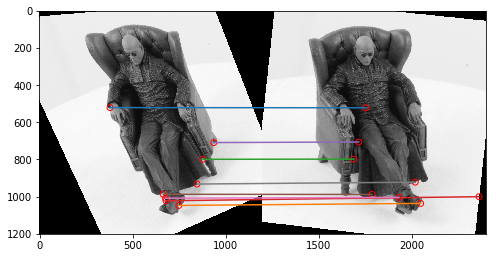

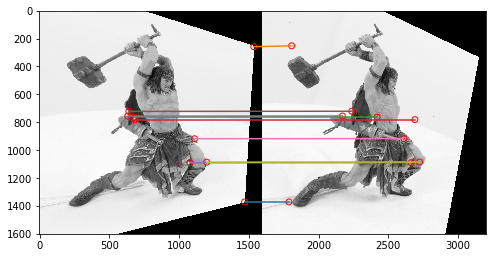

In [830]:
I1=imread("./p4/matrix/matrix0.png")
I2=imread("./p4/matrix/matrix1.png")
cor1 = np.load("./p4/matrix/cor1.npy")
cor2 = np.load("./p4/matrix/cor2.npy")
I3=imread("./p4/warrior/warrior0.png")
I4=imread("./p4/warrior/warrior1.png")
cor3 = np.load("./p4/warrior/cor1.npy")
cor4 = np.load("./p4/warrior/cor2.npy")

rectified_im1,rectified_im2,new_cor1,new_cor2 = image_rectification(I1,I2,cor1,cor2)
rectified_im3,rectified_im4,new_cor3,new_cor4 = image_rectification(I3,I4,cor3,cor4)

#decide the NCC matching window radius
R = 5
nCorners = 10
smoothSTD = 2
windowSize = 11
NCCth=0.71


F_new = fundamental_matrix(new_cor1, new_cor2)

# detect corners using corner detector here, store in corners1
corners1 = corner_detect(rectified_im1, nCorners, smoothSTD, windowSize)
corrs = correspondence_matching_epipole(rectified_im1, rectified_im2, corners1, F_new, R, NCCth)
display_correspondence(rectified_im1, rectified_im2, corrs)

F_new2=fundamental_matrix(new_cor3, new_cor4)

corners2 = corner_detect(rectified_im3, nCorners, smoothSTD, windowSize)
corrs = correspondence_matching_epipole(rectified_im3, rectified_im4, corners2, F_new2, R, NCCth)
display_correspondence(rectified_im3, rectified_im4, corrs)

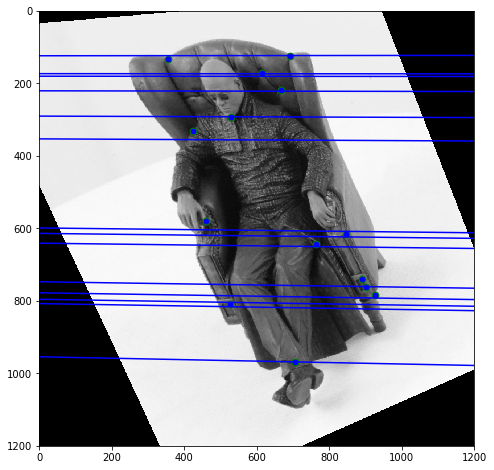

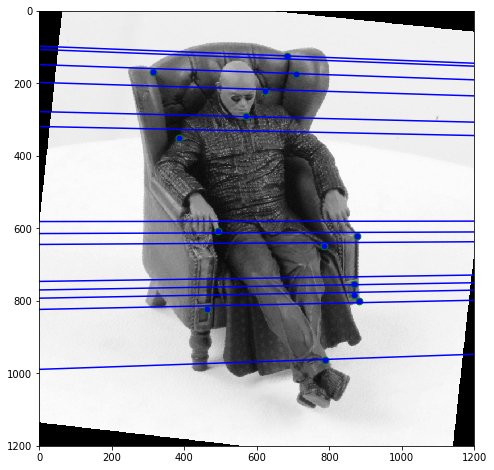

In [831]:
plot_epipolar_lines(rectified_im1,rectified_im2,new_cor1,new_cor2)

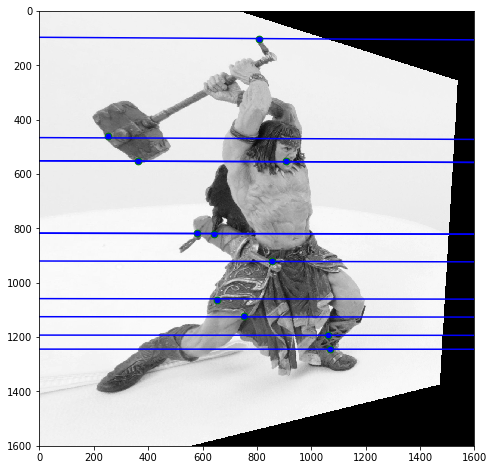

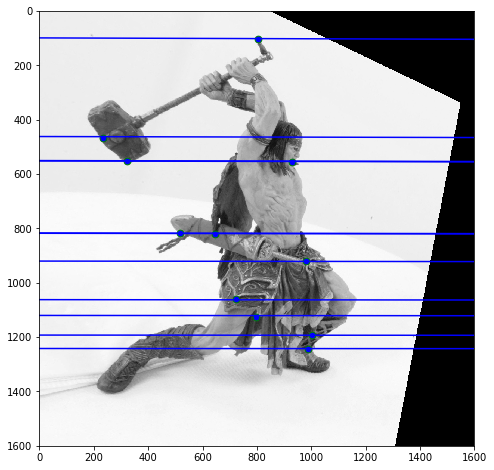

In [832]:
plot_epipolar_lines(rectified_im3,rectified_im4,new_cor3,new_cor4)